## Forecast Cab Booking Demand

### Context

Cab booking system is the process where renting a cab is automated through an app throughout a city. Using this app, people can book a cab from one location to another location. Being a cab booking app company, exploiting the understanding of cab supply and demand could increase the efficiency of their service and enhance user experience by minimizing waiting time

**Objective of this project is to combine historical usage pattern along with the open data sources like weather data,date and time to forecast cab booking demand in a city.**

In [2]:
import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,date
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import Sequential,layers

In [3]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_path =r"C:\Users\jbhsm\Master_Data\Reg\Cab_Booking_Forecast"

In [5]:
os.listdir(data_path)

['test.csv', 'test_label.csv', 'train.csv', 'train_label.csv']

**Loading Data**

In [6]:
def load_data(data_path):
    
    # Loading the Train dataset
    print("\nLoading Training Dataset...\n")
    df_train=pd.read_csv(os.path.join(data_path,'train.csv'))
    df_train_label=pd.read_csv(os.path.join(data_path,'train_label.csv'),header=None,names=['Target'])
    df_train['Target']=df_train_label.Target
    print("\nLoaded Training Dataset... Shape of Dataset is : ",df_train.shape)
    
    print("\nLoading Test Dataset...\n")
    # Preparing the Test Dataset
    df_test=pd.read_csv(os.path.join(data_path,'test.csv'))
    df_test_label=pd.read_csv(os.path.join(data_path,'test_label.csv'),header=None,names=['Target'])
    df_test['Target']=df_test_label.Target
    print("\nLoaded Test Dataset... Shape of Dataset is : ",df_test.shape)
    return df_train,df_test

In [7]:
df_train,df_test = load_data(data_path)


Loading Training Dataset...


Loaded Training Dataset... Shape of Dataset is :  (8708, 10)

Loading Test Dataset...


Loaded Test Dataset... Shape of Dataset is :  (2178, 10)


## Feature Engineering Modules

In [8]:
# Datetime feature engineering and extraction
def feat_dt_tm(df,column):
    
    print("\nProcessing DateTime objects and extracting features....\n")
    df_copy = copy.deepcopy(df)
    
    df_copy[column]=pd.to_datetime(df_copy[column])
    df_copy['month']=df_copy[column].dt.month
    df_copy['year']=df_copy[column].dt.year
    
    new_cols = ['month','year']
            
    return df_copy,new_cols

In [9]:
def feat_dummy_crt(df,column):
        
    print("\nOne Hot Encoding for {} feature....\n".format(column))
    
    df_copy = copy.deepcopy(df)
    
    df_dum = pd.get_dummies(df_copy,columns=[column])
    
    return df_dum

In [10]:
def feat_time(df,column,num_bins,crt_dum=False):
    
    print("\nProcessing DateTime to extract hour range features....\n")
    
    df_copy = copy.deepcopy(df)
    
    labels = [ "c"+str(i+1) for i in range(num_bins) ]
    
    df_copy['time_bins']=pd.cut(x=pd.to_datetime(df_copy[column]).dt.hour,bins=np.ceil(np.linspace(0,24,num_bins+1)),labels=labels)
    
    if crt_dum:
        df_copy = feat_dummy_crt(df_copy,'time_bins')
        
    return df_copy

In [11]:
def scale_min_max(df,cols):
    
    print("\nScaling each feature with respect to its own values...\n")
    df_copy = copy.deepcopy(df)
    
    scaler = MinMaxScaler()
    
    for col in cols:
        df_copy[col] = scaler.fit_transform(df[col].values.reshape(-1,1))
        
    return df_copy

In [12]:
def compile_feat_engg(df,num_bins,scale_cols,drop_cols):
    
    df_copy = copy.deepcopy(df)
    
    #Date time object processing
    df_interim,new_cols = feat_dt_tm(df_copy,'datetime')
    
    #Date time object processing for hour range features
    df_interim = feat_time(df_interim,'datetime',num_bins,crt_dum=True)
        
    #Weather feature processing
    df_interim = feat_dummy_crt(df_interim,"weather")
    
    #Season feature processing
    df_interim = feat_dummy_crt(df_interim,"season")
    
    #Scaling of features other than working day, holiday and target
    scale_cols.extend(new_cols)
    df_interim = scale_min_max(df_interim,scale_cols)
    
    print("\nDropping columns....\n")
    
    df_interim.drop(drop_cols,axis=1, inplace = True)
    
    print("\nFinal Data Frame Created....\n")
    return df_interim  

**Metrics Module**

In [13]:
def cal_score(y_test, y_pred): 
    mae  = mean_absolute_error(y_test, y_pred)
    rmse  = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test ,y_pred)
    
    return mae, rmse, r2, mape

In [14]:
def metrics_calculation(model_inst,training_data, testing_data, training_label, testing_label):
    
    result = []
    cols = ['Mean_Sc', 'Sc_std_dev','MAE', 'RMSE', 'R2_Score', 'MAPE']
    
    print("\nCalculating Cross Val Score....\n")
    
    crs_val     = cross_val_score(model_inst, training_data, training_label, cv=5)
    
    print("\nCalculating Mean and Std for Cross Val Score....\n")
    
    mean_score = round(np.mean(crs_val),3)
    std_score  = round(np.std(crs_val),3)
    
    print("\nFitting and Predicting Using regression model....\n")
    
    model_inst.fit(training_data, training_label)
    predictions = model_inst.predict(testing_data)
    
    print("\nCalculating Metrics....\n")
    mae, rmse, r2, mape = cal_score(testing_label, predictions)
    result.extend([mean_score,std_score, mae, rmse, r2, mape])
    series_result = pd.Series(data=result, index=cols)
    print("\nMetrics Calculation Ends....\n")
    return series_result,predictions,model_inst

In [15]:
def show_score_board(data,name=None,df=None):
    if df is None:
        scr_board_df = pd.DataFrame(data,columns=[name])
    elif isinstance(data,dict):
        interim_df = pd.DataFrame(data)
        scr_board_df = df.merge(interim_df,on=df.index)
        scr_board_df.set_index("key_0",inplace=True)
    else:
        interim_df = pd.DataFrame(data,columns=[name])
        scr_board_df = df.merge(interim_df,on=df.index)
    
    return scr_board_df

In [16]:
def test_df_ana(df,y_pred,num_bins):
    
    df_copy = copy.deepcopy(df)
    
    df_interim = feat_time(df_copy,'datetime',num_bins)
        
    df_interim["pred_target"]=list(y_pred)
    
    df_interim['tar_diff']=df_interim['pred_target']-df_interim['Target']
    
    df_interim['pred_bias'] = over_under(df_interim['tar_diff'].tolist())
    
    return df_interim

In [17]:
def over_under(lst):
    
    lst_final = ["Over" if num>0 else "Under" for num in lst]
    
    return lst_final

In [18]:
def data_prep(df_train,df_test,num_bins,scale_cols,drop_cols):
    
    print("\nRemoving Weather Feature Heavy Rain + Thunderstorm\n")
    # Since this has one value and test dataframe donot have aspect
    drop_index = df_train[df_train.weather==" Heavy Rain + Thunderstorm "].index[0]
    df_train_mod = df_train.drop(drop_index,axis=0)
    
    print("*"*100)
    
    print("\nCreating Engineered Training Data\n")
    df_tr_feat_engg = compile_feat_engg(df_train_mod,num_bins,scale_cols,drop_cols)
    print("*"*100)
    print("\nCreating Engineered Test Data\n")
    df_tst_feat_engg= compile_feat_engg(df_test,num_bins,scale_cols,drop_cols)
    
    print("*"*100)
    
    print("\nCreating Training Data Set X-y\n")
    X_train = df_tr_feat_engg.drop("Target",axis=1)
    y_train = df_tr_feat_engg.Target
    
    print("\nCreating Test Data Set X-y\n")
    X_test = df_tst_feat_engg.drop("Target",axis=1)
    y_test = df_tst_feat_engg.Target
    
    print("*"*100)
    
    return X_train,X_test,y_train,y_test

In [19]:
def model_execute(df_train,df_test,num_bins,scale_cols,drop_cols,model_best_param,model_exe_name):
       
    print("\nData Preparation\n")
    print("*"*100)
    X_train,X_test,y_train,y_test = data_prep(df_train,df_test,num_bins,scale_cols,drop_cols)

    print("\nChecking Model Performance\n")
    model_result,y_pred,model = metrics_calculation(model_best_param,X_train,X_test,y_train,y_test)
    
    print("*"*100)
    
    print("\nCreating Score Board\n")
    scr_board_df = show_score_board(model_result,model_exe_name)
        
    print("\nCreating Test Data Analysis DataFrame\n")
    df_tst_ana = test_df_ana(df_test,y_pred,num_bins)
    
    return df_tst_ana,scr_board_df,model

**Grid Search Module**

In [20]:
def grid_search(model_inst,params_reg,X_train,y_train):
    
    grid_obj = GridSearchCV(model_inst,params_reg,verbose=2,cv=3)
    
    grid_obj.fit(X_train,y_train)
    
    return grid_obj.cv_results_,grid_obj.best_estimator_,grid_obj.best_score_

**Outlier Handling Module**

In [21]:
def qntle_TQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    
    return Q1,Q3, IQR

In [22]:
def indx_ext_outl(df,tar_col):
   
    Q1,Q3, IQR = qntle_TQR(df)
    
    # Extracting the index of the dataframe, for which outlier exist in the Target column 
    X_outl_index=df[((df[tar_col]<(Q1[tar_col]-1.5*IQR[tar_col])) | (df[tar_col]>(Q3[tar_col]+1.5*IQR[tar_col])))].index
    X_wo_outl_index=df[~((df[tar_col]<(Q1[tar_col]-1.5*IQR[tar_col])) | (df[tar_col]>(Q3[tar_col]+1.5*IQR[tar_col])))].index
    
    return X_outl_index,X_wo_outl_index

In [23]:
def outlier_removal(df_train,df_test,tar_col):
    print("\nRemoving outlier from training data\n")
    print("*"*100)
    Target_outl_index_tr,Target_wo_outl_index_tr = indx_ext_outl(df_train,tar_col)
    
    df_train_wo_outl=df_train.loc[Target_wo_outl_index_tr]
   
    print(f"\nTraining data - No.of Obs with outlier {len(Target_outl_index_tr)} and No. of obs without outlier {len(Target_wo_outl_index_tr)}")
    
    print("\nRemoving outlier from Test data\n")
    
    Target_outl_index_tst,Target_wo_outl_index_tst = indx_ext_outl(df_test,tar_col)
    
    df_tst_wo_outl=df_test.loc[Target_wo_outl_index_tst]
    
    print(f"\nTest data - No.of Obs with outlier {len(Target_outl_index_tst)} and No. of obs without outlier {len(Target_wo_outl_index_tst)}\n")
    print("*"*100)    
    return df_train_wo_outl, df_tst_wo_outl  
    

In [24]:
# Seggregation of feature with respect to dtype

def feature_seg_dtype(df):
    
    lst_obj = df.select_dtypes(include='object').columns.to_list()
    
    lst_n_obj = df.select_dtypes(exclude='object').columns.to_list()
    
    return lst_obj,lst_n_obj

In [25]:
def box_plot(df,feat):
    
    #Plotting the box plot
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df[feat])
    plt.xticks(ticks=np.arange(len(feat)),labels=feat)
    plt.show()

In [26]:
def outlier_treatment(df_train,mul_fact,num_bins,tar_col):
    
    print("\nTreating Outlier\n")
    print("*"*100)
    df_copy = copy.deepcopy(df_train)
    
    df_interim = feat_time(df_copy,'datetime',num_bins)
    
    bins = df_interim['time_bins'].unique().tolist()
    bins=bins[:-1]
    
    c=0
    
    for bin_val in bins:
        
        df_temp =  df_interim[df_interim["time_bins"]==bin_val]
        
        Q1,Q3, IQR = qntle_TQR(df_temp)
                
#         X_outl_index=df_temp[(df_temp[tar_col]>(Q3[tar_col]+mul_fact*IQR[tar_col]))].index
        
        upper_clip_val = Q3[tar_col]+mul_fact*IQR[tar_col]
        
        
        print(f"\nClipping Values for bin {bin_val}")
        df_temp[tar_col]=np.clip(df_temp[tar_col].tolist(),None,upper_clip_val).tolist()
        
        if c==0:
            df_final =copy.deepcopy(df_temp)
        else:
            df_final = pd.concat([df_final,df_temp],axis=0)
            
        c+=1
    
    print("*"*100)
    print("\nCreating shuffled DataFrame")
    df_final = df_final.sample(frac = 1)    
        
    return df_final   

**Deep Learning Module**

In [27]:
def dl_model(X_train,activation,loss,optimizer,metrics):
    
    model=Sequential()
    model.add(layers.Dense(64,activation=activation,input_shape=[len(X_train.keys())]))
    model.add(layers.Dense(64,activation=activation))
    model.add(layers.Dense(1))
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
    
    print(model.summary())
                                                          
    return model

## Base Model Creation

In [28]:
num_bins = 5
scale_cols = ['atemp', 'humidity', 'windspeed']
drop_cols = ['temp','datetime']
model_exe_name = "Base_Model"
model_best_param = LinearRegression()

In [29]:
df_ana,scr_board_df,model = model_execute(df_train,df_test,num_bins,scale_cols,drop_cols,model_best_param,model_exe_name)


Data Preparation

****************************************************************************************************

Removing Weather Feature Heavy Rain + Thunderstorm

****************************************************************************************************

Creating Engineered Training Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....


One Hot Encoding for season feature....


Scaling each feature with respect to its own values...


Dropping columns....


Final Data Frame Created....

****************************************************************************************************

Creating Engineered Test Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....

In [30]:
scr_board_df

,Base_Model
Mean_Sc,0.584000
Sc_std_dev,0.010000
MAE,86.076389
RMSE,115.216659
R2_Score,0.587494
MAPE,3.246325


## Model 1 - Random Forest 

**Data Preparation**

In [31]:
num_bins = 5
scale_cols = ['atemp', 'humidity', 'windspeed']
drop_cols = ['temp','datetime']

In [32]:
X_train,X_test,y_train,y_test = data_prep(df_train,df_test,num_bins,scale_cols,drop_cols)


Removing Weather Feature Heavy Rain + Thunderstorm

****************************************************************************************************

Creating Engineered Training Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....


One Hot Encoding for season feature....


Scaling each feature with respect to its own values...


Dropping columns....


Final Data Frame Created....

****************************************************************************************************

Creating Engineered Test Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....


One Hot Encoding for season feature....


Scaling each feature with respect to its own values...


Dropping columns..

In [33]:
random_state = 42
params_reg = {'n_estimators':[200,300],'criterion': ['mse'],'max_depth':[8,10,12],'min_samples_split':[5,8,10],
              'min_samples_leaf':[5,8]}
model_inst = RandomForestRegressor(random_state=random_state)

In [39]:
results,best_estimator, best_scr = grid_search(model_inst,params_reg,X_train,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END criterion=mse, max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   2.9s
[CV] END criterion=mse, max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   3.1s
[CV] END criterion=mse, max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   3.0s
[CV] END criterion=mse, max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   4.6s
[CV] END criterion=mse, max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   4.6s
[CV] END criterion=mse, max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   4.6s
[CV] END criterion=mse, max_depth=8, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   3.1s
[CV] END criterion=mse, max_depth=8, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   3.1s
[CV] END criterion=

[CV] END criterion=mse, max_depth=10, min_samples_leaf=8, min_samples_split=10, n_estimators=300; total time=   5.1s


In [40]:
pd.DataFrame(results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.999979,0.094166,0.107379,0.012465,mse,8,5,5,200,"{'criterion': 'mse', 'max_depth': 8, 'min_samp...",0.737439,0.759317,0.734009,0.743588,0.011210,16
1,4.510942,0.009385,0.159904,0.023035,mse,8,5,5,300,"{'criterion': 'mse', 'max_depth': 8, 'min_samp...",0.738075,0.760094,0.734890,0.744353,0.011206,13
2,3.081426,0.008556,0.123671,0.008502,mse,8,5,8,200,"{'criterion': 'mse', 'max_depth': 8, 'min_samp...",0.737439,0.759317,0.734009,0.743588,0.011210,16
3,4.456084,0.271240,0.155915,0.017204,mse,8,5,8,300,"{'criterion': 'mse', 'max_depth': 8, 'min_samp...",0.738075,0.760094,0.734890,0.744353,0.011206,13
4,2.933508,0.168132,0.089095,0.020233,mse,8,5,10,200,"{'criterion': 'mse', 'max_depth': 8, 'min_samp...",0.737439,0.759317,0.734009,0.743588,0.011210,16
5,4.588064,0.129333,0.175198,0.011813,mse,8,5,10,300,"{'criterion': 'mse', 'max_depth': 8, 'min_samp...",0.738075,0.760094,0.734890,0.744353,0.011206,13
6,3.078765,0.010953,0.115026,0.001242,mse,8,8,5,200,"{'criterion': 'mse', 'max_depth': 8, 'min_samp...",0.736178,0.758511,0.732846,0.742512,0.011395,22
7,4.550335,0.055347,0.160917,0.015809,mse,8,8,5,300,"{'criterion': 'mse', 'max_depth': 8, 'min_samp...",0.736713,0.759285,0.733522,0.743173,0.011467,19
8,3.027244,0.012886,0.106049,0.010935,mse,8,8,8,200,"{'criterion': 'mse', 'max_depth': 8, 'min_samp...",0.736178,0.758511,0.732846,0.742512,0.011395,22
9,4.481702,0.119239,0.169214,0.001696,mse,8,8,8,300,"{'criterion': 'mse', 'max_depth': 8, 'min_samp...",0.736713,0.759285,0.733522,0.743173,0.011467,19


In [41]:
best_estimator

RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=300, random_state=42)

In [34]:
num_bins = 5
scale_cols = ['atemp', 'humidity', 'windspeed']
drop_cols = ['temp','datetime']
model_exe_name = "Rand_forst"
model_best_param = RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=300, random_state=42)

In [35]:
df_ana_rf,scr_board_df_rf,model_rf = model_execute(df_train,df_test,num_bins,scale_cols,drop_cols,
                                                   model_best_param,model_exe_name)


Data Preparation

****************************************************************************************************

Removing Weather Feature Heavy Rain + Thunderstorm

****************************************************************************************************

Creating Engineered Training Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....


One Hot Encoding for season feature....


Scaling each feature with respect to its own values...


Dropping columns....


Final Data Frame Created....

****************************************************************************************************

Creating Engineered Test Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....

In [36]:
scr_board_df_rf

,Rand_forst
Mean_Sc,0.754000
Sc_std_dev,0.007000
MAE,57.065286
RMSE,88.744606
R2_Score,0.755272
MAPE,0.826149


In [37]:
Final_Scr_board = show_score_board(scr_board_df_rf,model_exe_name,scr_board_df)

In [38]:
Final_Scr_board

,key_0,Base_Model,Rand_forst
0,Mean_Sc,0.584000,0.754000
1,Sc_std_dev,0.010000,0.007000
2,MAE,86.076389,57.065286
3,RMSE,115.216659,88.744606
4,R2_Score,0.587494,0.755272
5,MAPE,3.246325,0.826149


## Model 2 - Random Forest - without Outlier Data from Target

In [39]:
#Removing Outlier
df_train_wo_outl,df_test_wo_outl = outlier_removal(df_train,df_test,"Target")


Removing outlier from training data

****************************************************************************************************

Training data - No.of Obs with outlier 242 and No. of obs without outlier 8466

Removing outlier from Test data


Test data - No.of Obs with outlier 62 and No. of obs without outlier 2116

****************************************************************************************************


In [56]:
num_bins = 5
scale_cols = ['atemp', 'humidity', 'windspeed']
drop_cols = ['temp','datetime']
model_exe_name = "Rand_forst_wo_outl"
model_best_param = RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=300, random_state=42)

In [57]:
df_ana_rf_wo_outl,scr_board_df_rf_wo_outl,model_rf_wo_outl = model_execute(df_train_wo_outl,df_test_wo_outl,num_bins,scale_cols,drop_cols,
                                                   model_best_param,model_exe_name)


Data Preparation

****************************************************************************************************

Removing Weather Feature Heavy Rain + Thunderstorm

****************************************************************************************************

Creating Engineered Training Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....


One Hot Encoding for season feature....


Scaling each feature with respect to its own values...


Dropping columns....


Final Data Frame Created....

****************************************************************************************************

Creating Engineered Test Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....

In [58]:
scr_board_df_rf_wo_outl

,Rand_forst_wo_outl
Mean_Sc,0.760000
Sc_std_dev,0.006000
MAE,49.853608
RMSE,74.431549
R2_Score,0.767892
MAPE,0.832445


In [43]:
df_ana_rf_wo_outl.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Target,time_bins,pred_target,tar_diff,pred_bias
0,5/10/2012 11:00,Summer,0,1,Clear + Few clouds,21.32,25.000,48,35.0008,256,c3,265.161937,9.161937,Over
1,6/9/2012 7:00,Summer,0,0,Clear + Few clouds,23.78,27.275,64,7.0015,87,c2,185.413250,98.413250,Over
2,3/6/2011 20:00,Spring,0,0,"Light Snow, Light Rain",11.48,12.120,100,27.9993,11,c4,42.567347,31.567347,Over
3,10/13/2011 11:00,Winter,0,1,Mist + Cloudy,25.42,28.790,83,0.0000,84,c3,142.908307,58.908307,Over
4,6/2/2012 12:00,Summer,0,0,Clear + Few clouds,25.42,31.060,43,23.9994,668,c3,548.883180,-119.116820,Under


In [45]:
df_ana_rf_wo_outl.groupby("time_bins")["tar_diff"].mean()

time_bins
c1    -0.522062
c2   -23.795313
c3    -3.972807
c4   -34.867169
c5    -2.830440
Name: tar_diff, dtype: float64

In [55]:
df_ana_rf_wo_outl.groupby("time_bins")["Target"].std()

time_bins
c1     23.543787
c2    176.733512
c3    137.723278
c4    195.184262
c5     75.216542
Name: Target, dtype: float64

In [54]:
df_ana_rf_wo_outl.groupby("time_bins")["pred_target"].std()

time_bins
c1     13.673468
c2     83.504102
c3    117.967085
c4    127.881197
c5     58.786568
Name: pred_target, dtype: float64

<AxesSubplot:>

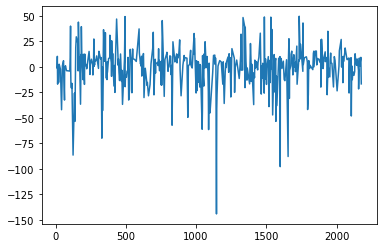

In [48]:
#For Time bin c1 - Under prediction is considerably higher
df_ana_rf_wo_outl[df_ana_rf_wo_outl['time_bins']=='c1']['tar_diff'].plot()

<AxesSubplot:>

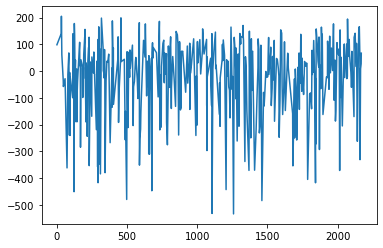

In [49]:
#For Time bin c2 - Under prediction is considerably higher
df_ana_rf_wo_outl[df_ana_rf_wo_outl['time_bins']=='c2']['tar_diff'].plot()

<AxesSubplot:>

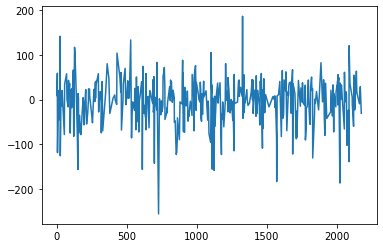

In [50]:
#For Time bin c3 - Under prediction is considerably higher
df_ana_rf_wo_outl[df_ana_rf_wo_outl['time_bins']=='c3']['tar_diff'].plot()

<AxesSubplot:>

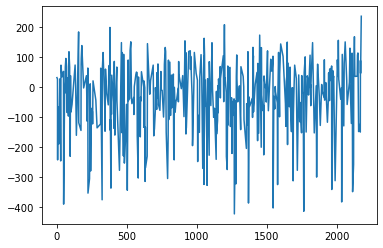

In [51]:
#For Time bin c4 - Under prediction is considerably higher
df_ana_rf_wo_outl[df_ana_rf_wo_outl['time_bins']=='c4']['tar_diff'].plot()

In [61]:
Final_Scr_board = show_score_board(scr_board_df_rf_wo_outl,model_exe_name,Final_Scr_board.set_index("key_0"))

In [62]:
Final_Scr_board

,key_0,Base_Model,Rand_forst,Rand_forst_wo_outl
0,Mean_Sc,0.584000,0.754000,0.760000
1,Sc_std_dev,0.010000,0.007000,0.006000
2,MAE,86.076389,57.065286,49.853608
3,RMSE,115.216659,88.744606,74.431549
4,R2_Score,0.587494,0.755272,0.767892
5,MAPE,3.246325,0.826149,0.832445


## Model 3- Deep Learning - without Outlier Data from Target

In [63]:
# Data Preparation
X_train,X_test,y_train,y_test = data_prep(df_train,df_test,num_bins,scale_cols,drop_cols)


Removing Weather Feature Heavy Rain + Thunderstorm

****************************************************************************************************

Creating Engineered Training Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....


One Hot Encoding for season feature....


Scaling each feature with respect to its own values...


Dropping columns....


Final Data Frame Created....

****************************************************************************************************

Creating Engineered Test Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....


One Hot Encoding for season feature....


Scaling each feature with respect to its own values...


Dropping columns..

In [64]:
activation = 'relu'
loss='mse'
optimizer = tf.keras.optimizers.RMSprop(0.001)
metrics = ['mae','mse']

In [65]:
model =  dl_model(X_train,activation,loss,optimizer,metrics)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1280      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
epochs = 500

In [67]:
history = model.fit(X_train,y_train,epochs=epochs,validation_split=0.2,verbose=1)

Epoch 1/500
218/218 [==============================] - 0s 2ms/step - loss: 50832.4141 - mae: 157.3008 - mse: 50832.4141 - val_loss: 24436.1582 - val_mae: 122.9430 - val_mse: 24436.1582
Epoch 2/500
218/218 [==============================] - 0s 1ms/step - loss: 23697.6328 - mae: 119.5902 - mse: 23697.6328 - val_loss: 17678.8379 - val_mae: 102.9237 - val_mse: 17678.8379
Epoch 3/500
218/218 [==============================] - 0s 1ms/step - loss: 17129.3809 - mae: 97.6177 - mse: 17129.3809 - val_loss: 13442.1904 - val_mae: 83.9538 - val_mse: 13442.1904
Epoch 4/500
218/218 [==============================] - 0s 992us/step - loss: 14040.6865 - mae: 84.4454 - mse: 14040.6865 - val_loss: 12492.0869 - val_mae: 77.7960 - val_mse: 12492.0869
Epoch 5/500
218/218 [==============================] - 0s 998us/step - loss: 13393.9111 - mae: 80.9509 - mse: 13393.9111 - val_loss: 12215.4238 - val_mae: 75.3631 - val_mse: 12215.4238
Epoch 6/500
218/218 [==============================] - 0s 1ms/step - loss: 13

218/218 [==============================] - 0s 991us/step - loss: 8409.7432 - mae: 61.2597 - mse: 8409.7432 - val_loss: 8457.1514 - val_mae: 60.4373 - val_mse: 8457.1514
Epoch 47/500
218/218 [==============================] - 0s 932us/step - loss: 8395.4248 - mae: 61.1908 - mse: 8395.4248 - val_loss: 8308.4521 - val_mae: 60.0641 - val_mse: 8308.4521
Epoch 48/500
218/218 [==============================] - 0s 960us/step - loss: 8394.7520 - mae: 61.1682 - mse: 8394.7520 - val_loss: 8280.4863 - val_mae: 60.0647 - val_mse: 8280.4863
Epoch 49/500
218/218 [==============================] - 0s 985us/step - loss: 8387.7598 - mae: 61.0198 - mse: 8387.7598 - val_loss: 8361.5283 - val_mae: 60.4986 - val_mse: 8361.5283
Epoch 50/500
218/218 [==============================] - 0s 930us/step - loss: 8368.6934 - mae: 61.0072 - mse: 8368.6934 - val_loss: 8356.1416 - val_mae: 60.2865 - val_mse: 8356.1416
Epoch 51/500
218/218 [==============================] - 0s 951us/step - loss: 8334.2207 - mae: 60.9073 

218/218 [==============================] - 0s 980us/step - loss: 8030.0601 - mae: 59.4586 - mse: 8030.0601 - val_loss: 8173.0708 - val_mae: 58.9290 - val_mse: 8173.0708
Epoch 92/500
218/218 [==============================] - 0s 962us/step - loss: 8055.2622 - mae: 59.4596 - mse: 8055.2622 - val_loss: 8155.2080 - val_mae: 58.6366 - val_mse: 8155.2080
Epoch 93/500
218/218 [==============================] - 0s 958us/step - loss: 8037.6699 - mae: 59.4986 - mse: 8037.6699 - val_loss: 8307.5195 - val_mae: 59.0039 - val_mse: 8307.5195
Epoch 94/500
218/218 [==============================] - 0s 958us/step - loss: 8041.4609 - mae: 59.5160 - mse: 8041.4609 - val_loss: 8108.3584 - val_mae: 58.6982 - val_mse: 8108.3584
Epoch 95/500
218/218 [==============================] - 0s 981us/step - loss: 8029.4888 - mae: 59.3614 - mse: 8029.4888 - val_loss: 8187.7373 - val_mae: 59.7835 - val_mse: 8187.7373
Epoch 96/500
218/218 [==============================] - 0s 961us/step - loss: 8027.9902 - mae: 59.4981 

218/218 [==============================] - 0s 957us/step - loss: 7723.3154 - mae: 57.9370 - mse: 7723.3154 - val_loss: 7918.0132 - val_mae: 57.7633 - val_mse: 7918.0132
Epoch 137/500
218/218 [==============================] - 0s 949us/step - loss: 7759.4688 - mae: 58.1036 - mse: 7759.4688 - val_loss: 7934.9912 - val_mae: 58.3801 - val_mse: 7934.9912
Epoch 138/500
218/218 [==============================] - 0s 984us/step - loss: 7726.9365 - mae: 57.9459 - mse: 7726.9365 - val_loss: 7942.8960 - val_mae: 58.2287 - val_mse: 7942.8960
Epoch 139/500
218/218 [==============================] - 0s 951us/step - loss: 7714.4165 - mae: 58.0653 - mse: 7714.4165 - val_loss: 8029.4023 - val_mae: 58.7479 - val_mse: 8029.4023
Epoch 140/500
218/218 [==============================] - 0s 975us/step - loss: 7731.5742 - mae: 58.1873 - mse: 7731.5742 - val_loss: 7953.0308 - val_mae: 58.8871 - val_mse: 7953.0308
Epoch 141/500
218/218 [==============================] - 0s 969us/step - loss: 7715.4565 - mae: 58.

Epoch 181/500
218/218 [==============================] - 0s 965us/step - loss: 7489.5352 - mae: 57.1848 - mse: 7489.5352 - val_loss: 8021.4380 - val_mae: 57.3911 - val_mse: 8021.4380
Epoch 182/500
218/218 [==============================] - 0s 1000us/step - loss: 7466.2949 - mae: 56.8304 - mse: 7466.2949 - val_loss: 8489.6260 - val_mae: 62.1408 - val_mse: 8489.6260
Epoch 183/500
218/218 [==============================] - 0s 978us/step - loss: 7492.0869 - mae: 57.2816 - mse: 7492.0869 - val_loss: 7879.5977 - val_mae: 57.3251 - val_mse: 7879.5977
Epoch 184/500
218/218 [==============================] - 0s 961us/step - loss: 7500.5620 - mae: 57.2690 - mse: 7500.5620 - val_loss: 7938.0366 - val_mae: 57.5796 - val_mse: 7938.0366
Epoch 185/500
218/218 [==============================] - 0s 1ms/step - loss: 7487.9282 - mae: 57.0095 - mse: 7487.9282 - val_loss: 7728.1919 - val_mae: 57.1167 - val_mse: 7728.1919
Epoch 186/500
218/218 [==============================] - 0s 996us/step - loss: 7481.48

218/218 [==============================] - 0s 961us/step - loss: 7360.6074 - mae: 56.4102 - mse: 7360.6074 - val_loss: 7938.6089 - val_mae: 57.5037 - val_mse: 7938.6089
Epoch 227/500
218/218 [==============================] - 0s 1ms/step - loss: 7336.9849 - mae: 56.4257 - mse: 7336.9849 - val_loss: 8156.6401 - val_mae: 57.5916 - val_mse: 8156.6401
Epoch 228/500
218/218 [==============================] - 0s 991us/step - loss: 7312.7427 - mae: 56.3013 - mse: 7312.7427 - val_loss: 7937.6196 - val_mae: 58.1888 - val_mse: 7937.6196
Epoch 229/500
218/218 [==============================] - 0s 974us/step - loss: 7321.5898 - mae: 56.4965 - mse: 7321.5898 - val_loss: 8046.5596 - val_mae: 57.1193 - val_mse: 8046.5596
Epoch 230/500
218/218 [==============================] - 0s 1ms/step - loss: 7343.2734 - mae: 56.4430 - mse: 7343.2734 - val_loss: 7817.3379 - val_mae: 58.0312 - val_mse: 7817.3379
Epoch 231/500
218/218 [==============================] - 0s 970us/step - loss: 7332.0171 - mae: 56.3461

218/218 [==============================] - 0s 999us/step - loss: 7236.6421 - mae: 55.7862 - mse: 7236.6421 - val_loss: 7797.0044 - val_mae: 57.2480 - val_mse: 7797.0044
Epoch 272/500
218/218 [==============================] - 0s 995us/step - loss: 7219.5234 - mae: 55.7629 - mse: 7219.5234 - val_loss: 7866.0488 - val_mae: 57.1286 - val_mse: 7866.0488
Epoch 273/500
218/218 [==============================] - 0s 964us/step - loss: 7198.0464 - mae: 55.7973 - mse: 7198.0464 - val_loss: 7798.7148 - val_mae: 58.2196 - val_mse: 7798.7148
Epoch 274/500
218/218 [==============================] - 0s 1ms/step - loss: 7229.5454 - mae: 55.7361 - mse: 7229.5454 - val_loss: 7750.1353 - val_mae: 57.3362 - val_mse: 7750.1353
Epoch 275/500
218/218 [==============================] - 0s 1ms/step - loss: 7206.3931 - mae: 55.7833 - mse: 7206.3931 - val_loss: 7862.8140 - val_mae: 57.4132 - val_mse: 7862.8140
Epoch 276/500
218/218 [==============================] - 0s 974us/step - loss: 7202.6440 - mae: 55.7869

Epoch 316/500
218/218 [==============================] - 0s 965us/step - loss: 7105.0278 - mae: 55.2584 - mse: 7105.0278 - val_loss: 7840.5957 - val_mae: 57.3594 - val_mse: 7840.5957
Epoch 317/500
218/218 [==============================] - 0s 1ms/step - loss: 7114.8237 - mae: 55.1783 - mse: 7114.8237 - val_loss: 7826.8857 - val_mae: 57.7214 - val_mse: 7826.8857
Epoch 318/500
218/218 [==============================] - 0s 964us/step - loss: 7101.7788 - mae: 55.3695 - mse: 7101.7788 - val_loss: 7780.9023 - val_mae: 57.0668 - val_mse: 7780.9023
Epoch 319/500
218/218 [==============================] - 0s 974us/step - loss: 7134.1294 - mae: 55.2984 - mse: 7134.1294 - val_loss: 7809.1279 - val_mae: 57.2173 - val_mse: 7809.1279
Epoch 320/500
218/218 [==============================] - 0s 972us/step - loss: 7104.5063 - mae: 55.3689 - mse: 7104.5063 - val_loss: 8065.1899 - val_mae: 57.5103 - val_mse: 8065.1899
Epoch 321/500
218/218 [==============================] - 0s 984us/step - loss: 7112.065

Epoch 361/500
218/218 [==============================] - 0s 989us/step - loss: 7036.1235 - mae: 55.0343 - mse: 7036.1235 - val_loss: 8165.6382 - val_mae: 57.6625 - val_mse: 8165.6382
Epoch 362/500
218/218 [==============================] - 0s 1ms/step - loss: 7047.0391 - mae: 54.7872 - mse: 7047.0391 - val_loss: 7722.8003 - val_mae: 57.0140 - val_mse: 7722.8003
Epoch 363/500
218/218 [==============================] - 0s 968us/step - loss: 7043.4321 - mae: 54.9614 - mse: 7043.4321 - val_loss: 7957.5098 - val_mae: 57.2740 - val_mse: 7957.5098
Epoch 364/500
218/218 [==============================] - 0s 954us/step - loss: 7022.5923 - mae: 54.8439 - mse: 7022.5923 - val_loss: 7804.6011 - val_mae: 57.4081 - val_mse: 7804.6011
Epoch 365/500
218/218 [==============================] - 0s 976us/step - loss: 7013.1904 - mae: 54.9023 - mse: 7013.1904 - val_loss: 7917.9766 - val_mae: 56.7795 - val_mse: 7917.9766
Epoch 366/500
218/218 [==============================] - 0s 975us/step - loss: 7012.520

Epoch 406/500
218/218 [==============================] - 0s 985us/step - loss: 6949.9736 - mae: 54.2973 - mse: 6949.9736 - val_loss: 7865.1235 - val_mae: 56.8409 - val_mse: 7865.1235
Epoch 407/500
218/218 [==============================] - 0s 943us/step - loss: 6945.6714 - mae: 54.4894 - mse: 6945.6714 - val_loss: 7801.1099 - val_mae: 57.2851 - val_mse: 7801.1099
Epoch 408/500
218/218 [==============================] - 0s 952us/step - loss: 6950.3047 - mae: 54.4258 - mse: 6950.3047 - val_loss: 7911.3306 - val_mae: 57.9283 - val_mse: 7911.3306
Epoch 409/500
218/218 [==============================] - 0s 957us/step - loss: 6929.8584 - mae: 54.3756 - mse: 6929.8584 - val_loss: 7708.7354 - val_mae: 57.0609 - val_mse: 7708.7354
Epoch 410/500
218/218 [==============================] - 0s 985us/step - loss: 6948.7695 - mae: 54.5037 - mse: 6948.7695 - val_loss: 7889.7715 - val_mae: 57.5374 - val_mse: 7889.7715
Epoch 411/500
218/218 [==============================] - 0s 980us/step - loss: 6937.8

Epoch 451/500
218/218 [==============================] - 0s 1ms/step - loss: 6885.2773 - mae: 54.0127 - mse: 6885.2773 - val_loss: 7905.7026 - val_mae: 56.8606 - val_mse: 7905.7026
Epoch 452/500
218/218 [==============================] - 0s 955us/step - loss: 6871.4009 - mae: 54.0098 - mse: 6871.4009 - val_loss: 7742.8848 - val_mae: 57.3248 - val_mse: 7742.8848
Epoch 453/500
218/218 [==============================] - 0s 949us/step - loss: 6895.6699 - mae: 54.1280 - mse: 6895.6699 - val_loss: 7724.1631 - val_mae: 56.6517 - val_mse: 7724.1631
Epoch 454/500
218/218 [==============================] - 0s 1ms/step - loss: 6849.8462 - mae: 54.0802 - mse: 6849.8462 - val_loss: 7994.5098 - val_mae: 56.6849 - val_mse: 7994.5098
Epoch 455/500
218/218 [==============================] - 0s 976us/step - loss: 6881.5361 - mae: 54.0957 - mse: 6881.5361 - val_loss: 7823.5254 - val_mae: 56.5790 - val_mse: 7823.5254
Epoch 456/500
218/218 [==============================] - 0s 998us/step - loss: 6877.2295 

Epoch 496/500
218/218 [==============================] - 0s 981us/step - loss: 6812.7144 - mae: 53.8101 - mse: 6812.7144 - val_loss: 8107.1284 - val_mae: 57.0946 - val_mse: 8107.1284
Epoch 497/500
218/218 [==============================] - 0s 958us/step - loss: 6800.9092 - mae: 53.7215 - mse: 6800.9092 - val_loss: 8175.8770 - val_mae: 57.2060 - val_mse: 8175.8770
Epoch 498/500
218/218 [==============================] - 0s 963us/step - loss: 6816.3530 - mae: 53.5905 - mse: 6816.3530 - val_loss: 7860.1016 - val_mae: 56.6012 - val_mse: 7860.1016
Epoch 499/500
218/218 [==============================] - 0s 1ms/step - loss: 6808.5825 - mae: 53.7678 - mse: 6808.5825 - val_loss: 7937.8901 - val_mae: 57.6276 - val_mse: 7937.8901
Epoch 500/500
218/218 [==============================] - 0s 985us/step - loss: 6798.8809 - mae: 53.7834 - mse: 6798.8809 - val_loss: 8013.2197 - val_mae: 57.1050 - val_mse: 8013.2197


In [68]:
y_pred = model.predict(X_test)
mae, rmse, r2, mape = cal_score(y_test, y_pred)

In [69]:
mae, rmse, r2, mape 

(57.14571513923841, 90.03311892850849, 0.7481138396277478, 0.6680248306538634)

In [99]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


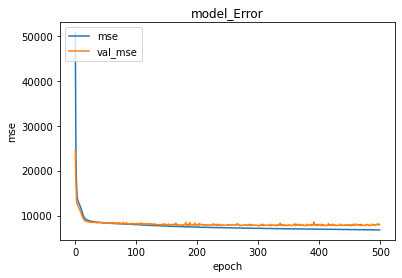

In [71]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model_Error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['mse', 'val_mse'], loc='upper left')
plt.show()

In [76]:
epochs = 300

In [77]:
model =  dl_model(X_train,activation,loss,optimizer,metrics)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                1280      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
history_150 = model.fit(X_train,y_train,epochs=epochs,validation_split=0.2,verbose=1)

Epoch 1/300
218/218 [==============================] - 0s 1ms/step - loss: 51544.1758 - mae: 159.0311 - mse: 51544.1758 - val_loss: 24877.3809 - val_mae: 123.6295 - val_mse: 24877.3809
Epoch 2/300
218/218 [==============================] - 0s 989us/step - loss: 24063.5527 - mae: 120.5953 - mse: 24063.5527 - val_loss: 17833.3555 - val_mae: 102.7492 - val_mse: 17833.3555
Epoch 3/300
218/218 [==============================] - 0s 1ms/step - loss: 17005.4102 - mae: 96.7731 - mse: 17005.4102 - val_loss: 13246.5537 - val_mae: 83.0328 - val_mse: 13246.5537
Epoch 4/300
218/218 [==============================] - 0s 991us/step - loss: 13973.7764 - mae: 84.2695 - mse: 13973.7764 - val_loss: 12444.5312 - val_mae: 78.3066 - val_mse: 12444.5312
Epoch 5/300
218/218 [==============================] - 0s 1ms/step - loss: 13383.1143 - mae: 81.4406 - mse: 13383.1143 - val_loss: 12214.7832 - val_mae: 77.6216 - val_mse: 12214.7832
Epoch 6/300
218/218 [==============================] - 0s 989us/step - loss: 

Epoch 46/300
218/218 [==============================] - 0s 943us/step - loss: 8328.7881 - mae: 60.5181 - mse: 8328.7881 - val_loss: 8218.1650 - val_mae: 59.8302 - val_mse: 8218.1650
Epoch 47/300
218/218 [==============================] - 0s 951us/step - loss: 8336.0342 - mae: 60.5213 - mse: 8336.0342 - val_loss: 8383.0723 - val_mae: 60.2227 - val_mse: 8383.0723
Epoch 48/300
218/218 [==============================] - 0s 935us/step - loss: 8349.8467 - mae: 60.4910 - mse: 8349.8467 - val_loss: 8212.1963 - val_mae: 58.8428 - val_mse: 8212.1963
Epoch 49/300
218/218 [==============================] - 0s 931us/step - loss: 8317.2041 - mae: 60.5204 - mse: 8317.2041 - val_loss: 8329.0547 - val_mae: 59.4319 - val_mse: 8329.0547
Epoch 50/300
218/218 [==============================] - 0s 974us/step - loss: 8320.0176 - mae: 60.2866 - mse: 8320.0176 - val_loss: 8234.7393 - val_mae: 58.7312 - val_mse: 8234.7393
Epoch 51/300
218/218 [==============================] - 0s 947us/step - loss: 8313.9912 - 

218/218 [==============================] - 0s 1ms/step - loss: 8020.1704 - mae: 58.9211 - mse: 8020.1704 - val_loss: 8113.6841 - val_mae: 58.9766 - val_mse: 8113.6841
Epoch 92/300
218/218 [==============================] - 0s 1ms/step - loss: 8011.0015 - mae: 59.0656 - mse: 8011.0015 - val_loss: 8165.3198 - val_mae: 58.3897 - val_mse: 8165.3198
Epoch 93/300
218/218 [==============================] - 0s 1ms/step - loss: 8006.2144 - mae: 59.0086 - mse: 8006.2144 - val_loss: 8177.4634 - val_mae: 59.3373 - val_mse: 8177.4634
Epoch 94/300
218/218 [==============================] - 0s 1ms/step - loss: 8010.6514 - mae: 58.9639 - mse: 8010.6514 - val_loss: 8050.5151 - val_mae: 58.0535 - val_mse: 8050.5151
Epoch 95/300
218/218 [==============================] - 0s 965us/step - loss: 8014.4995 - mae: 58.9354 - mse: 8014.4995 - val_loss: 8134.6445 - val_mae: 57.9880 - val_mse: 8134.6445
Epoch 96/300
218/218 [==============================] - 0s 1ms/step - loss: 7987.6450 - mae: 58.8055 - mse: 798

218/218 [==============================] - 0s 989us/step - loss: 7814.1021 - mae: 58.0067 - mse: 7814.1021 - val_loss: 8164.2710 - val_mae: 57.7100 - val_mse: 8164.2710
Epoch 137/300
218/218 [==============================] - 0s 988us/step - loss: 7785.4595 - mae: 57.8208 - mse: 7785.4595 - val_loss: 8030.3232 - val_mae: 58.8874 - val_mse: 8030.3232
Epoch 138/300
218/218 [==============================] - 0s 963us/step - loss: 7776.8569 - mae: 57.8350 - mse: 7776.8569 - val_loss: 7996.4839 - val_mae: 57.9537 - val_mse: 7996.4839
Epoch 139/300
218/218 [==============================] - 0s 960us/step - loss: 7784.6973 - mae: 57.9219 - mse: 7784.6973 - val_loss: 7975.6104 - val_mae: 57.5250 - val_mse: 7975.6104
Epoch 140/300
218/218 [==============================] - 0s 956us/step - loss: 7739.6279 - mae: 57.7902 - mse: 7739.6279 - val_loss: 8097.9473 - val_mae: 57.6854 - val_mse: 8097.9473
Epoch 141/300
218/218 [==============================] - 0s 971us/step - loss: 7770.1636 - mae: 57.

Epoch 181/300
218/218 [==============================] - 0s 958us/step - loss: 7619.4814 - mae: 57.1157 - mse: 7619.4814 - val_loss: 7974.7090 - val_mae: 58.0109 - val_mse: 7974.7090
Epoch 182/300
218/218 [==============================] - 0s 987us/step - loss: 7601.6855 - mae: 57.1647 - mse: 7601.6855 - val_loss: 8263.8398 - val_mae: 57.9704 - val_mse: 8263.8398
Epoch 183/300
218/218 [==============================] - 0s 951us/step - loss: 7589.3833 - mae: 56.8808 - mse: 7589.3833 - val_loss: 8099.2261 - val_mae: 57.5524 - val_mse: 8099.2261
Epoch 184/300
218/218 [==============================] - 0s 1ms/step - loss: 7599.0288 - mae: 56.9875 - mse: 7599.0288 - val_loss: 7963.3540 - val_mae: 57.8783 - val_mse: 7963.3540
Epoch 185/300
218/218 [==============================] - 0s 959us/step - loss: 7580.9468 - mae: 56.9857 - mse: 7580.9468 - val_loss: 8067.2295 - val_mae: 59.1026 - val_mse: 8067.2295
Epoch 186/300
218/218 [==============================] - 0s 960us/step - loss: 7593.110

Epoch 226/300
218/218 [==============================] - 0s 938us/step - loss: 7477.9263 - mae: 56.4775 - mse: 7477.9263 - val_loss: 7985.5220 - val_mae: 57.5131 - val_mse: 7985.5220
Epoch 227/300
218/218 [==============================] - 0s 963us/step - loss: 7447.9058 - mae: 56.4285 - mse: 7447.9058 - val_loss: 7966.3164 - val_mae: 57.4725 - val_mse: 7966.3164
Epoch 228/300
218/218 [==============================] - 0s 951us/step - loss: 7438.5386 - mae: 56.4344 - mse: 7438.5386 - val_loss: 8296.1025 - val_mae: 58.2635 - val_mse: 8296.1025
Epoch 229/300
218/218 [==============================] - 0s 968us/step - loss: 7460.9448 - mae: 56.3886 - mse: 7460.9448 - val_loss: 7957.0020 - val_mae: 57.3974 - val_mse: 7957.0020
Epoch 230/300
218/218 [==============================] - 0s 984us/step - loss: 7456.0527 - mae: 56.5485 - mse: 7456.0527 - val_loss: 8130.2554 - val_mae: 57.6189 - val_mse: 8130.2554
Epoch 231/300
218/218 [==============================] - 0s 942us/step - loss: 7416.6

Epoch 271/300
218/218 [==============================] - 0s 960us/step - loss: 7298.2407 - mae: 55.7621 - mse: 7298.2407 - val_loss: 8019.5156 - val_mae: 58.0448 - val_mse: 8019.5156
Epoch 272/300
218/218 [==============================] - 0s 944us/step - loss: 7299.9810 - mae: 55.7645 - mse: 7299.9810 - val_loss: 7908.7231 - val_mae: 57.5850 - val_mse: 7908.7231
Epoch 273/300
218/218 [==============================] - 0s 941us/step - loss: 7306.3472 - mae: 55.7634 - mse: 7306.3472 - val_loss: 8009.8848 - val_mae: 57.4748 - val_mse: 8009.8848
Epoch 274/300
218/218 [==============================] - 0s 963us/step - loss: 7304.3989 - mae: 55.7752 - mse: 7304.3989 - val_loss: 7893.6792 - val_mae: 57.3824 - val_mse: 7893.6792
Epoch 275/300
218/218 [==============================] - 0s 972us/step - loss: 7271.0894 - mae: 55.8068 - mse: 7271.0894 - val_loss: 7959.8052 - val_mae: 57.6049 - val_mse: 7959.8052
Epoch 276/300
218/218 [==============================] - 0s 1ms/step - loss: 7285.028

In [79]:
y_pred = model.predict(X_test)
mae, rmse, r2, mape = cal_score(y_test, y_pred)
mae, rmse, r2, mape 

(57.22844239721832, 90.02921459882833, 0.7481356854840249, 0.7088862755599644)

In [80]:
Final_Scr_board.set_index("key_0", inplace=True)

In [81]:
Final_Scr_board["Dl_wo_outl"]=[0,0,mae, rmse, r2, mape]

In [82]:
Final_Scr_board

,Base_Model,Rand_forst,Rand_forst_wo_outl,Dl_wo_outl
key_0,,,,
Mean_Sc,0.584000,0.754000,0.760000,0.000000
Sc_std_dev,0.010000,0.007000,0.006000,0.000000
MAE,86.076389,57.065286,49.853608,57.228442
RMSE,115.216659,88.744606,74.431549,90.029215
R2_Score,0.587494,0.755272,0.767892,0.748136
MAPE,3.246325,0.826149,0.832445,0.708886


### Thoughts

    *Random Forest without Outlier provides the best RMSE, which is approximately 33% improvement over the Base Model

In [116]:
df_ana_rf_wo_outl.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Target,time_bins,pred_target,tar_diff,pred_bias
0,5/10/2012 11:00,Summer,0,1,Clear + Few clouds,21.32,25.000,48,35.0008,256,c3,265.161937,9.161937,Over
1,6/9/2012 7:00,Summer,0,0,Clear + Few clouds,23.78,27.275,64,7.0015,87,c2,185.413250,98.413250,Over
2,3/6/2011 20:00,Spring,0,0,"Light Snow, Light Rain",11.48,12.120,100,27.9993,11,c4,42.567347,31.567347,Over
3,10/13/2011 11:00,Winter,0,1,Mist + Cloudy,25.42,28.790,83,0.0000,84,c3,142.908307,58.908307,Over
5,4/1/2011 23:00,Summer,0,1,Clear + Few clouds,12.30,15.910,61,6.0032,53,c5,53.870454,0.870454,Over


In [123]:
lst_obg, lst_n_obj = feature_seg_dtype(df_ana_rf_wo_outl)

In [ ]:
df_ana_rf_wo_outl[df_ana_rf_wo_outl.time_bins=='c2']   

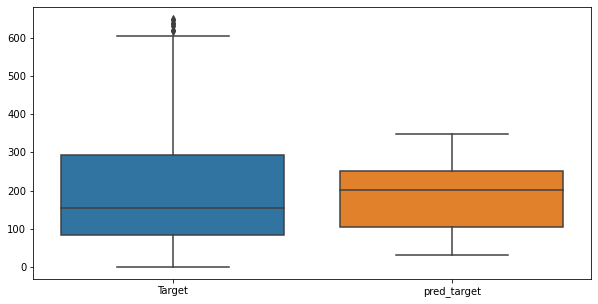

In [127]:
box_plot(df_ana_rf_wo_outl[df_ana_rf_wo_outl.time_bins=='c2'],['Target','pred_target'])

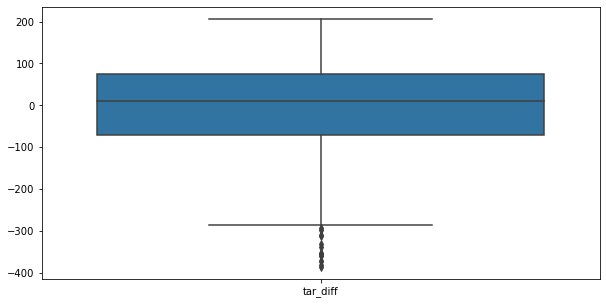

In [132]:
box_plot(df_ana_rf_wo_outl[df_ana_rf_wo_outl.time_bins=='c2'],['tar_diff']) #Huge under prediction

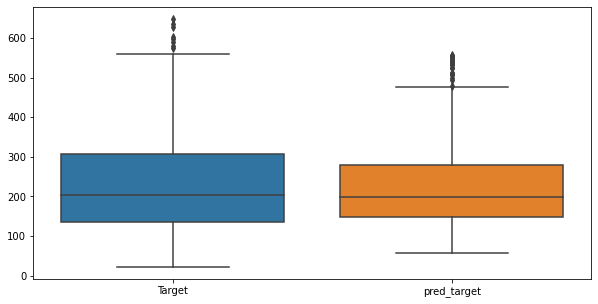

In [128]:
box_plot(df_ana_rf_wo_outl[df_ana_rf_wo_outl.time_bins=='c3'],['Target','pred_target'])

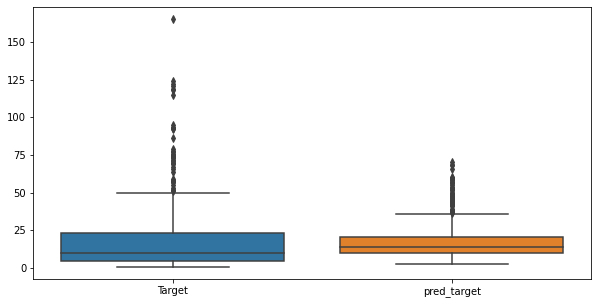

In [129]:
box_plot(df_ana_rf_wo_outl[df_ana_rf_wo_outl.time_bins=='c1'],['Target','pred_target'])

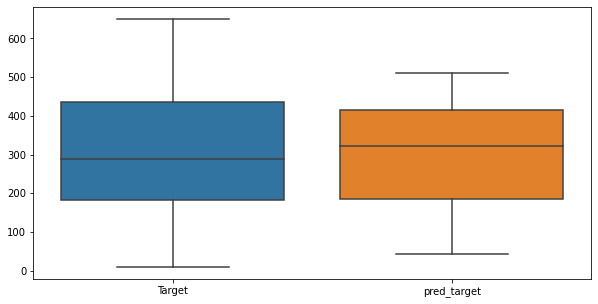

In [130]:
box_plot(df_ana_rf_wo_outl[df_ana_rf_wo_outl.time_bins=='c4'],['Target','pred_target'])

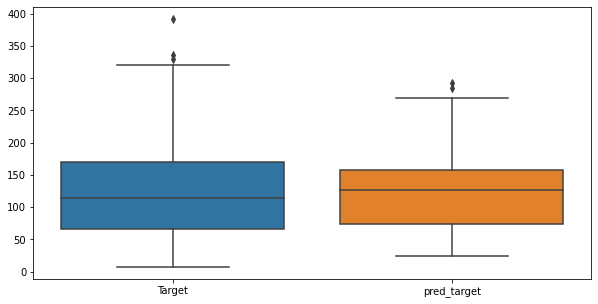

In [131]:
box_plot(df_ana_rf_wo_outl[df_ana_rf_wo_outl.time_bins=='c5'],['Target','pred_target'])

In [83]:
from xgboost import XGBRegressor

In [84]:
model = XGBRegressor()

In [85]:
num_bins = 5
scale_cols = ['atemp', 'humidity', 'windspeed']
drop_cols = ['temp','datetime']
model_exe_name = "XGB"
model_best_param = XGBRegressor()

In [86]:
df_ana_rf_wo_outl,scr_board_df_rf_wo_outl,model_rf_wo_outl = model_execute(df_train_wo_outl,df_test_wo_outl,num_bins,scale_cols,drop_cols,
                                                   model_best_param,model_exe_name)


Data Preparation

****************************************************************************************************

Removing Weather Feature Heavy Rain + Thunderstorm

****************************************************************************************************

Creating Engineered Training Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....


One Hot Encoding for season feature....


Scaling each feature with respect to its own values...


Dropping columns....


Final Data Frame Created....

****************************************************************************************************

Creating Engineered Test Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....

In [87]:
scr_board_df_rf_wo_outl

,XGB
Mean_Sc,0.740000
Sc_std_dev,0.006000
MAE,52.196086
RMSE,77.004763
R2_Score,0.751566
MAPE,0.953387


In [100]:
random_state = 42
params_reg = {'n_estimators':[200,300],'criterion': ['mse'],'max_depth':[8,10],'min_samples_split':[5],
              'min_samples_leaf':[5,8],'learning_rate':[0.05],'booster':['gbtree'],'reg_alpha':[0.5,0.7]}
model_inst = XGBRegressor(random_state=random_state)

In [89]:
num_bins = 5
scale_cols = ['atemp', 'humidity', 'windspeed']
drop_cols = ['temp','datetime']

In [90]:
# Data Preparation
X_train,X_test,y_train,y_test = data_prep(df_train_wo_outl,df_test_wo_outl,num_bins,scale_cols,drop_cols)


Removing Weather Feature Heavy Rain + Thunderstorm

****************************************************************************************************

Creating Engineered Training Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....


One Hot Encoding for season feature....


Scaling each feature with respect to its own values...


Dropping columns....


Final Data Frame Created....

****************************************************************************************************

Creating Engineered Test Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....


One Hot Encoding for season feature....


Scaling each feature with respect to its own values...


Dropping columns..

In [101]:
results,best_estimator, best_scr = grid_search(model_inst,params_reg,X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[13:11:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion", "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END booster=gbtree, criterion=mse, learning_rate=0.05, max_depth=8, min_samples_leaf=5, min_samples_split=5, n_estimators=200, reg_alpha=0.5; total time=   1.1s
[13:11:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion", "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used

[CV] END booster=gbtree, criterion=mse, learning_rate=0.05, max_depth=8, min_samples_leaf=8, min_samples_split=5, n_estimators=200, reg_alpha=0.5; total time=   1.0s
[13:12:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion", "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END booster=gbtree, criterion=mse, learning_rate=0.05, max_depth=8, min_samples_leaf=8, min_samples_split=5, n_estimators=200, reg_alpha=0.5; total time=   1.0s
[13:12:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion", "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some paramete

[CV] END booster=gbtree, criterion=mse, learning_rate=0.05, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200, reg_alpha=0.7; total time=   1.7s
[13:12:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion", "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END booster=gbtree, criterion=mse, learning_rate=0.05, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200, reg_alpha=0.7; total time=   1.8s
[13:12:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion", "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parame

[CV] END booster=gbtree, criterion=mse, learning_rate=0.05, max_depth=10, min_samples_leaf=8, min_samples_split=5, n_estimators=200, reg_alpha=0.7; total time=   1.8s
[13:13:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion", "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END booster=gbtree, criterion=mse, learning_rate=0.05, max_depth=10, min_samples_leaf=8, min_samples_split=5, n_estimators=300, reg_alpha=0.5; total time=   2.5s
[13:13:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion", "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parame

In [102]:
best_estimator

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, criterion='mse', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=8,
             min_child_weight=1, min_samples_leaf=5, min_samples_split=5,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, random_state=42, reg_alpha=0.5, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [99]:
best_scr

0.7510687661119251

In [109]:
num_bins = 5
scale_cols = ['atemp', 'humidity', 'windspeed']
drop_cols = ['temp','datetime']
model_exe_name = "XGB_wo_outl"
model_best_param = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, criterion='mse', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=8,
             min_child_weight=1, min_samples_leaf=5, min_samples_split=5,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, random_state=42, reg_alpha=0.5, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [110]:
df_ana_xgb_wo_outl,scr_board_df_xgb_wo_outl,model_xgb_wo_outl = model_execute(df_train_wo_outl,df_test_wo_outl,num_bins,scale_cols,drop_cols,
                                                   model_best_param,model_exe_name)


Data Preparation

****************************************************************************************************

Removing Weather Feature Heavy Rain + Thunderstorm

****************************************************************************************************

Creating Engineered Training Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....


One Hot Encoding for season feature....


Scaling each feature with respect to its own values...


Dropping columns....


Final Data Frame Created....

****************************************************************************************************

Creating Engineered Test Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....

In [141]:
scr_board_df_xgb_wo_outl

,XGB_wo_outl
Mean_Sc,0.756000
Sc_std_dev,0.010000
MAE,50.116619
RMSE,75.436559
R2_Score,0.761582
MAPE,0.798158


In [115]:
Final_Scr_board = show_score_board(scr_board_df_xgb_wo_outl,model_exe_name,Final_Scr_board.set_index("key_0"))

In [116]:
Final_Scr_board

,key_0,Base_Model,Rand_forst,Rand_forst_wo_outl,Dl_wo_outl,XGB_wo_outl
0,Mean_Sc,0.584000,0.754000,0.760000,0.000000,0.756000
1,Sc_std_dev,0.010000,0.007000,0.006000,0.000000,0.010000
2,MAE,86.076389,57.065286,49.853608,57.228442,50.116619
3,RMSE,115.216659,88.744606,74.431549,90.029215,75.436559
4,R2_Score,0.587494,0.755272,0.767892,0.748136,0.761582
5,MAPE,3.246325,0.826149,0.832445,0.708886,0.798158


## Final Thoughts

**Consideirng Random Forest without outlier model**


Removing Weather Feature Heavy Rain + Thunderstorm

****************************************************************************************************

Creating Engineered Training Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....


One Hot Encoding for season feature....


Scaling each feature with respect to its own values...


Dropping columns....


Final Data Frame Created....

****************************************************************************************************

Creating Engineered Test Data


Processing DateTime objects and extracting features....


Processing DateTime to extract hour range features....


One Hot Encoding for time_bins feature....


One Hot Encoding for weather feature....


One Hot Encoding for season feature....


Scaling each feature with respect to its own values...


Dropping columns..

<AxesSubplot:>

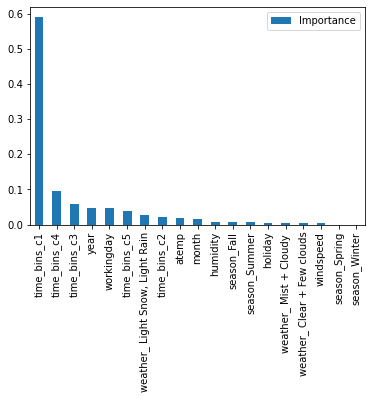

In [151]:
#Getting the columns
X_train,_,_,_ = data_prep(df_train,df_test,num_bins,scale_cols,drop_cols)
df_imp = pd.DataFrame(model_rf_wo_outl.feature_importances_,index=X_train.columns,columns=['Importance'])
df_imp.sort_values('Importance',ascending=False).plot(kind="bar")

In [152]:
# Since this has one value and test dataframe donot have aspect
drop_index = df_train[df_train.weather==" Heavy Rain + Thunderstorm "].index[0]
df_train_mod = df_train.drop(drop_index,axis=0)

df_train_time_bin = feat_time(df_train_mod,'datetime',5)


Processing DateTime to extract hour range features....



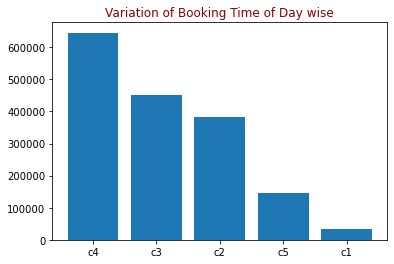

In [153]:
time_grp_df=df_train_time_bin.groupby('time_bins')['Target'].sum().sort_values(ascending=False)
plt.bar(time_grp_df.index,time_grp_df.values)
plt.title("Variation of Booking Time of Day wise",color='DarkRed')
plt.show()

In [117]:
df_ana_rf_wo_outl.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Target,time_bins,pred_target,tar_diff,pred_bias
0,5/10/2012 11:00,Summer,0,1,Clear + Few clouds,21.32,25.000,48,35.0008,256,c3,240.442795,-15.557205,Under
1,6/9/2012 7:00,Summer,0,0,Clear + Few clouds,23.78,27.275,64,7.0015,87,c2,184.339203,97.339203,Over
2,3/6/2011 20:00,Spring,0,0,"Light Snow, Light Rain",11.48,12.120,100,27.9993,11,c4,11.742810,0.742810,Over
3,10/13/2011 11:00,Winter,0,1,Mist + Cloudy,25.42,28.790,83,0.0000,84,c3,113.051849,29.051849,Over
5,4/1/2011 23:00,Summer,0,1,Clear + Few clouds,12.30,15.910,61,6.0032,53,c5,37.092422,-15.907578,Under


In [144]:
Final_Analysis_df = df_ana_rf_wo_outl.groupby('time_bins')['Target'].mean().astype("int32").reset_index()

In [145]:
Final_Analysis_df

,time_bins,Target
0,c1,18
1,c2,194
2,c3,228
3,c4,308
4,c5,127


In [146]:
Final_Analysis_pred_df = df_ana_rf_wo_outl.groupby('time_bins')['pred_target'].mean().astype("int32").reset_index()

In [147]:
Final_Analysis_pred_df

,time_bins,pred_target
0,c1,17
1,c2,183
2,c3,223
3,c4,296
4,c5,122


In [148]:
Final_Analysis_df_1 = Final_Analysis_df.merge(Final_Analysis_pred_df,on='time_bins')
Final_Analysis_df_1

,time_bins,Target,pred_target
0,c1,18,17
1,c2,194,183
2,c3,228,223
3,c4,308,296
4,c5,127,122


In [149]:
Final_Analysis_df_1.set_index('time_bins',inplace=True)
Final_Analysis_df_1["Tar_diff"]=Final_Analysis_df_1["Target"]-Final_Analysis_df_1["pred_target"]

In [150]:
Final_Analysis_df_1

,Target,pred_target,Tar_diff
time_bins,,,
c1,18,17,1
c2,194,183,11
c3,228,223,5
c4,308,296,12
c5,127,122,5


In [156]:
#Logical RMSE
mae, rmse, r2, mape = cal_score(Final_Analysis_df_1["Target"], Final_Analysis_df_1["pred_target"])
print(f"\nLogical RMSE is {np.round(rmse,2)}\n")


Logical RMSE is 7.95



#### Concluding Thoughts

    * The most critical factor from business point of view is the availability of the rolling stock.
    * Cab Booking with respect to time of day - gets maximum importance for the prediction model.
    * Average rolling stock avaiability with respect to the time of the day donot show much variation. 
    * With Logical RMSE approx 8, will subtantially help the company in financial saving owing to budget allocation in fuel, 
    * manpower and investment in rolling stock